In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
default_path = "<drive path to files>"

### Loading Data

In [3]:
import pandas as pd
import torch
import random
import numpy as np

Training Data

In [4]:
train = pd.read_csv(default_path+"train.csv")
train.head()

,headline,article
0,EXCLUSIVE: दिल्ली में डीजल टैक्सियों पर बैन से...,दिल्ली में सुप्रीम कोर्ट के डीज़ल टैक्सियों को...
1,जॉर्डन: राष्ट्रपति मुखर्जी ने 86 करोड़ डॉलर के...,जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प...
2,UN में पाकिस्तान की राजदूत मलीहा लोधी ने कराई ...,पाकिस्तानी नेताओं को विवादित और हास्यास्पद बया...
3,38 देशों में पीएम नरेंद्र मोदी बायोपिक को रिली...,पीएम नरेंद्र मोदी बायोपिक में विवेक ओबेरॉय ने ...
4,13 अगस्त 2011: दिनभर की बड़ी खबरें पढ़ें,"देश, दुनिया, महानगर, खेल, आर्थिक और बॉलीवुड मे..."


In [5]:
print(train.head(1)["headline"])

0    EXCLUSIVE: दिल्ली में डीजल टैक्सियों पर बैन से...
Name: headline, dtype: object


In [6]:
train.shape

(266607, 2)

Testing Data

In [7]:
test = pd.read_csv(default_path+"news_data.csv")
test.shape

(66653, 2)

In [8]:
test.head(5)

,headline,article
0,"पठानकोट पहुंचे PM मोदी, एयरबेस का जायजा ले बॉर...",प्रधानमंत्री नरेंद्र मोदी पठानकोट एयरबेस पहुंच...
1,सचिन ने देशवासियों को समर्पित किया अपना दोहरा शतक,सचिन तेंदुलकर ने एकदिवसीय अंतरराष्ट्रीय क्रिके...
2,एनआईए करेगी छत्तीसगढ़ में सुरक्षा खामियों की ज...,केंद्रीय गृह राज्य मंत्री आर. पी. एन. सिंह ने ...
3,सीधी बात: शाह बोले- हमारा बस चलता तो अब तक मं...,भारतीय जनता पार्टी (बीजेपी) के राष्ट्रीय अध्यक...
4,"ऋषभ पंत के पास यूनिक टैलेंट, उसके साथ छेड़छाड़ न...",ऋषभ पंत की कभी कभार इस बात के लिए आलोचना की जा...


In [9]:
news = pd.concat([train, test], ignore_index=True, sort=False)

In [10]:
news.shape

(333260, 2)

### Cleaning

In [ ]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def preprocess_tokenize(text):
      # for removing punctuation from sentencesc
    text = str(text)
    text = re.sub(r'(\d+)', r'', text)
    
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\u200d', '')
    text=re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text=re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text=re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text=re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text=re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively
    text=re.sub(r"[<>()|&©@#ø\[\]\'\",;:?.~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    text = re.sub(r"[‘’।:]", " ", str(text)) #removing other special characters
    text = re.sub("([a-zA-Z])",' ',str(text)).lower()
    text = re.sub("(\s+)",' ',str(text)).lower()
    text = remove_emojis(text)
    return text


In [ ]:
train_data_trg = news['headline']
train_data_src = news['article']

In [ ]:
tokenized_corpus_trg = [preprocess_tokenize(x) for x in train_data_trg]  #these are headlines
tokenized_corpus_src = [preprocess_tokenize(x) for x in train_data_src]  #these are articles

In [ ]:
tokenized_corpus_src[1] #cleaned sentences

'जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प्रणब मुखर्जी ने करोड़ डॉलर की लागत से निर्मित भारत-जॉर्डन उवर्रक संयंत्र का जॉर्डन के शाह अब्दुल्ला द्वितीय इब्न अल हुसैन के साथ उद्घाटन किया यह संयंत्र एक साल से कम समय में बनकर तैयार हुआ है राष्ट्रपति मुखर्जी के यहां एयर इंडिया की उड़ान से दोपहर पहुंचने के कुछ देर बाद ही शाह के महल से इस संयंत्र का रिमोट के जरिए उद्घाटन किया गया अधिकारियों ने बताया कि भारतीय उर्वरक कंपनी इफको और जॉर्डन के फास्फेट्स माइन कंपनी ने इस संयंत्र के लिए में एक संयुक्त उद्यम कंपनी जॉर्डन इंडिया फर्टिलाइजर कंपनी बनाया संयुक्त उद्यम में इफको की हिस्सेदारी प्रतिशत है इस संयंत्र से प्रति वर्ष करोड़ टन सल्फ्यूरिक एसिड और करोड़ टन फास्फेरिक एसिड के उत्पादन का अनुमान है राष्ट्रपति का इससे पहले यहां पारंपरिक स्वागत किया गया और राष्ट्रपति भवन के सामने उन्हें तोपों की सलामी दी गई इसके बाद वह शाह अब्दुल्ला द्वितीय इब्न अल हुसैन के साथ वार्ता में व्यस्त हो गए वार्ता के बाद दोनों नेताओं ने इंडो-जर्मन उवर्रक संयंत्र का संयुक्त रूप से उद्घाटन किया इस संयंत्र से कच्चे माल का उत

### Deciding max len and dictionary size

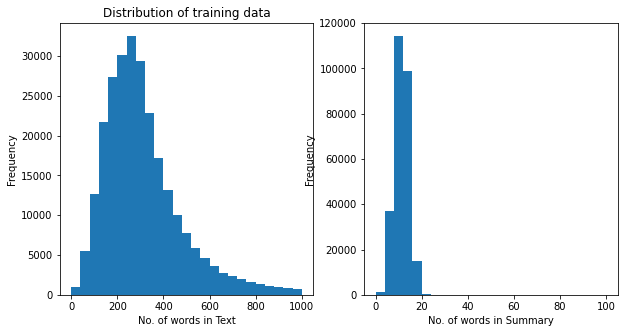

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in tokenized_corpus_src[:train.shape[0]]:
      text_word_count.append(len(i.split()))

for i in tokenized_corpus_trg[:train.shape[0]]:
      summary_word_count.append(len(i.split()))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].hist(text_word_count, bins=25, range=[0, 1000])
ax[1].hist(summary_word_count, bins=25, range=[0, 100])
ax[0].set_xlabel("No. of words in Text")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("No. of words in Summary")
ax[1].set_ylabel("Frequency")
ax[0].set_title('Distribution of training data')
plt.show()

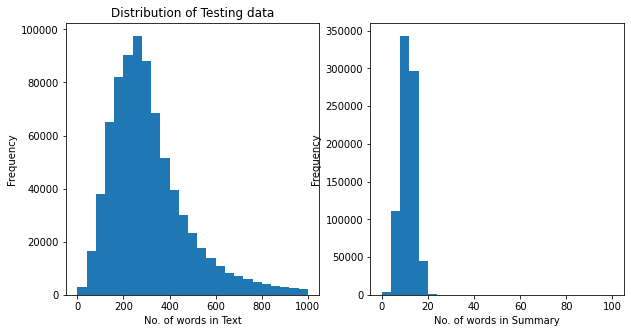

In [ ]:
for i in tokenized_corpus_src[:-test.shape[0]]:
      text_word_count.append(len(i.split()))

for i in tokenized_corpus_trg[:-test.shape[0]]:
      summary_word_count.append(len(i.split()))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].hist(text_word_count, bins=25, range=[0, 1000])
ax[1].hist(summary_word_count, bins=25, range=[0, 100])
ax[0].set_xlabel("No. of words in Text")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("No. of words in Summary")
ax[1].set_ylabel("Frequency")
ax[0].set_title('Distribution of Testing data')
plt.show()

In [ ]:
news['Text_Cleaned'] = tokenized_corpus_src  
print("::::: Text_Cleaned :::::")
print(news['Text_Cleaned'][0:5], "\n")


news['Summary_Cleaned'] =  tokenized_corpus_trg 
print("::::: Summary :::::")
print(news['Summary_Cleaned'][0:5], "\n")

corpus = list(news['Text_Cleaned'])


::::: Text_Cleaned :::::
0    दिल्ली में सुप्रीम कोर्ट के डीज़ल टैक्सियों को...
1    जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प...
2    पाकिस्तानी नेताओं को विवादित और हास्यास्पद बया...
3    पीएम नरेंद्र मोदी बायोपिक में विवेक ओबेरॉय ने ...
4    देश दुनिया महानगर खेल आर्थिक और बॉलीवुड में क्...
Name: Text_Cleaned, dtype: object 

::::: Summary :::::
0     दिल्ली में डीजल टैक्सियों पर बैन से मुश्किल म...
1    जॉर्डन राष्ट्रपति मुखर्जी ने करोड़ डॉलर के संय...
2     में पाकिस्तान की राजदूत मलीहा लोधी ने कराई फज...
3     देशों में पीएम नरेंद्र मोदी बायोपिक को रिलीज ...
4                      अगस्त दिनभर की बड़ी खबरें पढ़ें
Name: Summary_Cleaned, dtype: object 



In [ ]:
text_count = []
summary_count = []

for sent in news['Text_Cleaned']:
    text_count.append(len(sent.split()))
for sent in news['Summary_Cleaned']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()
graph_df['text'] = text_count
graph_df['summary'] = summary_count

In [ ]:
graph_df['text'].describe()

count    333260.000000
mean        348.910493
std         314.028859
min           0.000000
25%         197.000000
50%         282.000000
75%         399.000000
max       15089.000000
Name: text, dtype: float64

In [ ]:
graph_df['summary'].describe()


count    333260.000000
mean         10.842576
std           3.001873
min           0.000000
25%           9.000000
50%          11.000000
75%          13.000000
max         162.000000
Name: summary, dtype: float64

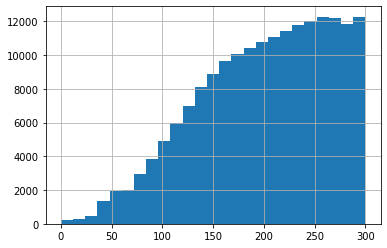

In [ ]:
graph_df['text'].hist(bins = 25, range=(0, 300))
plt.show()


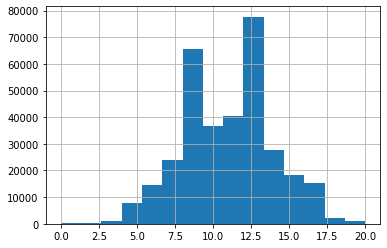

In [ ]:
graph_df['summary'].hist(bins = 15, range=(0, 20))
plt.show()


In [ ]:
count = 0
for i in graph_df['text']:
    if i > 10 and i <= 300:
        count = count + 1
print(count / len(graph_df['text']))


0.5509842165276361


In [ ]:
count = 0
for i in graph_df['summary']:
    if i > 1 and i <= 20:
        count = count + 1
print(count / len(graph_df['summary']))

0.9994118706115346


In [ ]:
max_text_len = 300
max_summary_len = 16


In [ ]:
cleaned_text = np.array(news['Text_Cleaned'])
cleaned_summary = np.array(news['Summary_Cleaned'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len 
       and len(cleaned_summary[i].split()) > 1 
       and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
    elif((len(cleaned_summary[i].split()) > max_summary_len) or (len(cleaned_text[i].split()) > max_text_len)):
        summ = cleaned_summary[i].split()
        txt = cleaned_text[i].split()
        if(len(summ)>max_summary_len):
          short_summary.append(' '.join(summ[:max_summary_len]))
        else:
          short_summary.append(cleaned_summary[i])
        if(len(txt)>max_text_len):
          short_text.append(' '.join(txt[:max_text_len]))
        else:
          short_text.append(cleaned_text[i]) 
    
post_pre = pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
post_pre['text'] = post_pre['text'].apply(lambda x: 'sostok ' + x + ' eostok')

In [ ]:
post_pre.shape

(333143, 2)

In [ ]:
cleaned_summary = np.array(post_pre['summary'])
cleaned_text = np.array(post_pre['text'])
print("cleaned text's size ",cleaned_text.shape)
print("cleaned summary's size ",cleaned_summary.shape)

cleaned text's size  (333143,)
cleaned summary's size  (333143,)


### Tokenizer and Padding

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#Tokenize text to get the vocab count
#prepare a tokenizer for training data
text_tokenizer = Tokenizer() 
text_tokenizer.fit_on_texts(list(cleaned_text))

#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer()   
summary_tokenizer.fit_on_texts(list(cleaned_summary))

In [ ]:
vocab = text_tokenizer.word_index
import random
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

print(sample_from_dict(vocab))

{'“याचिकाकर्ता': 221385, 'केशवचन्द्र': 158522, 'रामधनु': 126226, 'एंग': 94482, 'बर्टोलूसी': 208227, 'मतांजिमा': 277157, 'बाहडेई': 353641, 'मुस्लीमानी': 293851, 'टीएटी': 321408, 'हबाईपुर': 207593}


In [ ]:
len(vocab)

353646

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in text_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 68.68167602630879
Total Coverage of rare words: 0.41351097036187695


In [ ]:
# #prepare a tokenizer for reviews on training data
text_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
text_tokenizer.fit_on_texts(list(cleaned_text))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
text__seq    =   text_tokenizer.texts_to_sequences(cleaned_text)
#padding zero upto maximum length
cleaned_text    =   pad_sequences(text__seq,  maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
text_voc   =  text_tokenizer.num_words + 1

print("Size of vocabulary in text = {}".format(text_voc))

Size of vocabulary in text = 110757


In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in summary_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.05363524028988
Total Coverage of rare words: 1.1603857371100994


In [ ]:
#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
summary_tokenizer.fit_on_texts(list(cleaned_summary))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
summary__seq    =   summary_tokenizer.texts_to_sequences(cleaned_summary)
#padding zero upto maximum length
cleaned_summary    =   pad_sequences(summary__seq,  maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
summary_voc   =  summary_tokenizer.num_words + 1

print("Size of vocabulary in summary = {}".format(summary_voc))

Size of vocabulary in summary = 25121


In [ ]:
summary_tokenizer.word_counts['sostok'],len(cleaned_summary)

(333143, 333143)

In [ ]:
import pickle

with open(default_path+'text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'summary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
ind=[]
for i in range(len(cleaned_summary)):
    cnt=0
    for j in cleaned_summary[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

cleaned_text = np.delete(cleaned_text, ind, axis=0)
cleaned_summary = np.delete(cleaned_summary, ind, axis=0)

In [ ]:
print("cleaned text's size ",cleaned_text.shape)
print("cleaned summary's size ",cleaned_summary.shape)

cleaned text's size  (333130, 300)
cleaned summary's size  (333130, 16)


In [ ]:
cleaned_text

array([[   24,    56,     2, ...,     0,     0,     0],
       [11094,     1,  1708, ...,   162,  3278,    25],
       [   24,   580,   333, ...,     0,     0,     0],
       ...,
       [    6,   580,   665, ..., 18583,     8,    25],
       [   24,  2442,  1083, ...,     0,     0,     0],
       [   24,   310,     1, ...,     0,     0,     0]], dtype=int32)

In [ ]:
cleaned_summary

array([[    1,    21,     3, ...,     2,     0,     0],
       [    1,  9770,   206, ...,     0,     0,     0],
       [    1,     3,    68, ...,     2,     0,     0],
       ...,
       [    1,    68,     9, ...,     0,     0,     0],
       [   94,    23,    12, ..., 17783, 11079,     2],
       [    1,     4,    26, ...,     2,     0,     0]], dtype=int32)

### Saving Final Input Text

In [ ]:
with open(default_path+'cleaned_text.pickle', 'wb') as handle:
    pickle.dump(cleaned_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'cleaned_summary.pickle', 'wb') as handle:
    pickle.dump(cleaned_summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Embedding Space

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.0 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3145175 sha256=bfc82251de90f7ed268ed54b54ca7b1077f3f37e407b5f27071ce05fff6c959d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext.util

In [ ]:
#fasttext.util.download_model('hi', if_exists='ignore')  # Hindi

In [ ]:
ft = fasttext.load_model(default_path+'cc.hi.300.bin')

In [ ]:
word = "नृत्य"
print("Embedding vector shape is {}".format(ft.get_word_vector(word).shape[0]))

Embedding vector shape is 300


### Embedding Matrix - Get Vectors

In [ ]:
def create_weight_matrix(model, DICT_SIZE, tokenizer):
  '''
  Accepts word embedding model
  and the second model, if provided
  Returns weight matrix of size m*n, where
  m - size of the dictionary
  n - size of the word embedding vector

  '''
  vector_size = model.get_word_vector("नृत्य").shape[0]
  w_matrix = np.zeros((DICT_SIZE, vector_size))
  unk_words = []
  text_words = []
  for word, index in tokenizer.word_index.items():
    if index < DICT_SIZE:
      if word in model.words: 
        w_matrix[index] = model.get_word_vector(word)
        text_words.append(word)
      else:
        w_matrix[index] = np.random.rand(1, vector_size)
        unk_words.append(word)
        
  
  print('{} words were considered as they were found in embedding space:'.format(len(text_words)))
  print('{} are some such words'.format(text_words[:10]))
  print()  
  print('{} words were randomly alloted as they were not found in embedding space:'.format(len(unk_words)))
  print('{} are some such words'.format(unk_words[:10]))

  return w_matrix

In [ ]:
text_matrix = create_weight_matrix(ft, text_voc, text_tokenizer)

101084 words were considered as they were found in embedding space:
['के', 'में', 'है', 'की', 'को', 'ने', 'से', 'और', 'का', 'पर'] are some such words

9672 words were randomly alloted as they were not found in embedding space:
['sostok', 'eostok', 'सिंबा', 'जेजेपी', 'एयरस्ट्राइक', 'रियलमी', 'इनपुटः', 'मीटू', 'एनालिटिका', 'आर्काइव्ड'] are some such words


In [ ]:
summ_matrix = create_weight_matrix(ft, summary_voc, summary_tokenizer)

24917 words were considered as they were found in embedding space:
['में', 'के', 'की', 'का', 'ने', 'से', 'को', 'पर', 'है', 'नहीं'] are some such words

203 words were randomly alloted as they were not found in embedding space:
['sostok', 'eostok', 'एयरस्ट्राइक', 'दीपवीर', 'सिंबा', 'फरीदाबादः', 'रसूखदारः', 'ओडिशाः', 'मिजाजः', 'तेलंगानाः'] are some such words


### Saving Embedding Matrices

In [ ]:
with open(default_path+'text_matrix.pickle', 'wb') as handle:
    pickle.dump(text_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'summ_matrix.pickle', 'wb') as handle:
    pickle.dump(summ_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Model

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import time
import re
import pickle
import matplotlib.pyplot as plt 

### Loading Cleaned Dataset

In [11]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [13]:
with open(default_path+'cleaned_text.pickle', 'rb') as handle:
    cleaned_text = pickle.load(handle)
with open(default_path+'cleaned_summary.pickle', 'rb') as handle:
    cleaned_summary = pickle.load(handle)

In [14]:
cleaned_text.shape

(86629, 300)

#### Train Test Split

In [15]:
x_train, y_train = cleaned_text[:cleaned_text.shape[0]-test.shape[0], :], cleaned_summary[:cleaned_summary.shape[0]-test.shape[0], :]
x_test, y_test = cleaned_text[:-test.shape[0], :], cleaned_summary[:-test.shape[0], :]

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

### Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [17]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [18]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [19]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [20]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Building the Model

#### Scaled Dot Product

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

### Feed Forward Network

In [23]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Fundamental Unit of Transformer encoder

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, emb_matrix, max_len, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_dim = input_vocab_size, 
                      output_dim = d_model,
                      input_length = max_len, # max_len of text sequence - 300
                      weights=[emb_matrix],
                      trainable=False) # static weights to be assigned from pretrained embedding
        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [27]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, emb_matrix, max_len, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        #self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.embedding = tf.keras.layers.Embedding(input_dim = target_vocab_size, 
                      output_dim = d_model,
                      input_length = max_len, # max_len of summ sequence - 16
                      weights=[emb_matrix],
                      trainable=False)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, text_matrix, max_len_text, summ_matrix, max_len_summ, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, text_matrix, max_len_text, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, summ_matrix, max_len_summ, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [29]:
with open(default_path+'text_matrix.pickle', 'rb') as handle:
    text_matrix = pickle.load(handle)
with open(default_path+'summ_matrix.pickle', 'rb') as handle:
    summ_matrix = pickle.load(handle)

In [31]:
# hyper-params
num_layers = 4
d_model = text_matrix.shape[1]
dff = 512
num_heads = 10
EPOCHS = 20
max_len_text = 300
max_len_summ = 16

In [30]:
encoder_vocab_size = 110757
decoder_vocab_size = 25121

#### Adam optimizer with custom learning rate scheduling

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### Custom Loss and Accuracy Functions

In [34]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [36]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [38]:
val_loss = tf.keras.metrics.Mean(name='val_loss')

#### Transformer

In [39]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input = encoder_vocab_size, 
    pe_target = decoder_vocab_size,
    text_matrix = text_matrix, 
    max_len_text = max_len_text, 
    summ_matrix = summ_matrix, 
    max_len_summ = max_len_summ
)

#### Masks

In [40]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [41]:
checkpoint_path = default_path+"checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#### Training steps

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

### Test Validation Steps

In [ ]:
@tf.function
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
    val_loss(loss)

In [ ]:
train_loss_values = []
test_loss_values = []
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    val_loss.reset_states()
    #training set - forward prop, loss fn, (gradient descent and optimization) backprop
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # 85k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 85k / 64 ~ 1328; 1328 / 2 ~ 664
        if batch % 2601 == 0:
            print ('Epoch {} ========> Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result().numpy()))
      
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    train_loss_values.append(train_loss.result().numpy())
    
    #test set - forward pass, loss fn (no backward pass)
    for (batch, (inp, tar)) in enumerate(test_dataset):
        val_step(inp, tar)

    test_loss_values.append(val_loss.result().numpy())
    
    print ('Epoch {}/{} ========> Training Loss {:.4f} Test/Validation Loss {:.4f}'.format(epoch + 1, EPOCHS, train_loss.result().numpy(), val_loss.result().numpy()))
    
    print ('Time taken for epoch {}: {:.2f} secs\n'.format(epoch+1, time.time() - start))

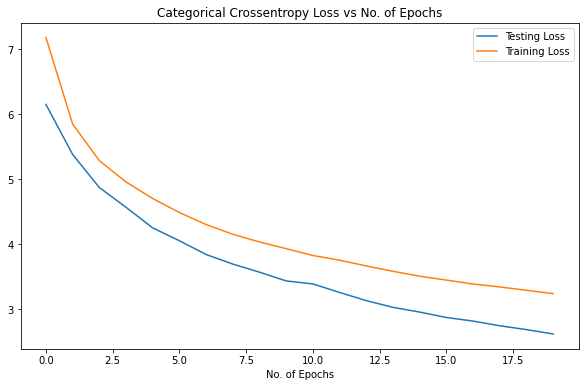

In [ ]:
no_of_epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
ax.plot(no_of_epochs, test_loss_values, label = 'Testing Loss')
ax.plot(no_of_epochs, train_loss_values, label = 'Training Loss')
ax.set_title('Categorical Crossentropy Loss vs No. of Epochs')
ax.legend()
ax.set_xlabel("No. of Epochs")
plt.show()

#### Predicting one word at a time at the decoder and appending it to the output; then taking the complete sequence as an input to the decoder and repeating until maxlen or stop keyword appears

In [42]:
with open(default_path+'text_tokenizer.pickle', 'rb') as handle:
    text_tokenizer = pickle.load(handle)
with open(default_path+'summary_tokenizer.pickle', 'rb') as handle:
    summary_tokenizer = pickle.load(handle)
max_text_len = 300
max_summary_len = 16

In [43]:
def predict(input_document):
    # #clean
    #input_document = preprocess_tokenize(input_document)
    input_document = "sostok "+input_document+" eostok"
    #tokenize
    input_document = text_tokenizer.texts_to_sequences([input_document])
    #padding
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=max_text_len, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["sostok"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_summary_len):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask,
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["eostok"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [44]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = predict(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [45]:
summarize("पूर्व प्रधानमंत्री और कांग्रेस के दिग्गज नेता राजीव गांधी की आज 75वीं जयंती है. इस मौके पर कांग्रेस अध्यक्ष राहुल गांधी, यूपीए चेयरपर्सन सोनिया गांधी, प्रियंका गांधी, पूर्व प्रधानमंत्री मनमोहन सिंह समेत कई बड़े कांग्रेस नेताओं ने उन्हें श्रद्धांजलि अर्पित की. प्रधानमंत्री नरेंद्र मोदी ने भी ट्वीट कर उन्हें श्रद्धांजलि दी. बता दें कि राजीव गांधी का जन्म आज ही के दिन 1944 में हुआ था. 21 मई, 1991 को उनकी हत्या कर दी गई थी. राजीव गांधी 1984 से 1989 तक प्रधानमंत्री रहे. तमिलनाडु के श्रीपेरंबुदुर में 21 मई, 1991 को आम चुनाव के प्रचार के दौरान एलटीटीई के एक आत्मघाती हमलावर ने राजीव गांधी की हत्या कर दी थी. 1984 में इंदिरा गांधी की हत्या के बाद वह भारी बहुमत के साथ प्रधानमंत्री बने. राजीव गांधी की राजनीति में कोई रूचि नहीं थी और वो एक एयरलाइन पायलट की नौकरी करते थे और उसी में खुश थे. लेकिन आपातकाल के उपरान्त जब इंदिरा गांधी को सत्ता छोड़नी पड़ी थी. वहीं साल 1980 में छोटे भाई संजय गांधी की हवाई जहाज दुर्घटना में मृत्यु हो जाने के बाद माता इंदिरा का सहयोग देने के लिए उन्होंने राजनीति में प्रवेश कर लिया.")

'राजीव गांधी की पुण्यतिथि पर प्रधानमंत्री नरेंद्र मोदी ने दी श्रद्धांजलि'

#### Output

In [46]:
documents = test["article"]
summary = test["headline"]

In [50]:
samples = [17, 35, 69, 21, 26]
docs = []
summ = []
pred = []
for i in samples:
  pred.append(summarize(documents[i]))
  docs.append(' '.join(documents[i].split(' ')[:100]))
  summ.append(summary[i])


result_df = pd.DataFrame({'Input': docs, 'Reference Summary': summ, 'Model Output Summary': pred, 'Padding':pred })
result_df[['Input', 'Reference Summary', 'Model Output Summary']] #17, 69, 21, 26, 35
result_df.style.set_properties(subset=['Input', 'Padding'], **{'width': '400px'})

,Input,Reference Summary,Model Output Summary,Padding
0,"इराक की राजधानी बगदाद में सोमवार को दो आत्मघाती हमले हुए. अधिकारियों ने जानकारी देते हुए कहा कि इस दोहरे आत्मघाती हमले में 26 लोगों की मौत हो गई. आपको बता दें कि इराकी राजधानी में पिछले तीन दिनों में हुआ यह दूसरा हमला है. पूर्वी बगदाद के स्वास्थ्य प्रमुख डॉ अब्देल गनी अल-सादी ने ‘‘26 लोगों के मारे जाने और 90 के घायल होने” की जानकारी दी. सेना और पुलिस की संयुक्त ऑपरेशन्स कमान के प्रवक्ता जनरल साद मान ने बताया, “मध्य बगदाद के अल-तय्यारन चौराहे पर दो आत्मघाती हमलावरों ने खुद को धमाका कर उड़ा लिया.” इराक के बगदाद का तय्यारन चौराहा","इराक के बगदाद में दोहरा आत्मघाती हमला, 26 लोगों की मौत",इराक में आत्मघाती हमले में लोगों की मौत,इराक में आत्मघाती हमले में लोगों की मौत
1,दिल्ली से सटे नोएडा के ग्राम बंबावड़ में एक महिला की मौत के मामले में ससुराल पक्ष पर दहेज हत्या का मामला दर्ज किया गया है. महिला के पिता ने उसके पति समेत छह लोगों के खिलाफ थाना बादलपुर में मामला दर्ज कराया है. पुलिस उपाधीक्षक दादरी निशांक शर्मा ने बताया कि गांव सौराजपुर के रहने वाले विनोद कुमार ने थाना बादलपुर में रिपोर्ट दर्ज कराई कि उनकी बेटी मोनिका की शादी गांव बंबावड़ के रहने वाले अक्षय के साथ हुई थी. शादी के समय से ही उसके ससुराल वाले कार और नगदी की मांग कर रहे थे. मांग पूरी ना होने,"ससुराल में महिला की संदिग्ध मौत, दहेज हत्या का केस दर्ज",दहेज के लिए महिला की हत्या,दहेज के लिए महिला की हत्या
2,"पूर्व प्रधानमंत्री और कांग्रेस के दिग्गज नेता राजीव गांधी की आज 75वीं जयंती है. इस मौके पर कांग्रेस अध्यक्ष राहुल गांधी, यूपीए चेयरपर्सन सोनिया गांधी, प्रियंका गांधी, पूर्व प्रधानमंत्री मनमोहन सिंह समेत कई बड़े कांग्रेस नेताओं ने उन्हें श्रद्धांजलि अर्पित की. प्रधानमंत्री नरेंद्र मोदी ने भी ट्वीट कर उन्हें श्रद्धांजलि दी. बता दें कि राजीव गांधी का जन्म आज ही के दिन 1944 में हुआ था. 21 मई, 1991 को उनकी हत्या कर दी गई थी. Tributes to our former Prime Minister Shri Rajiv Gandhi Ji on his birth anniversary. We remember his efforts towards the nation. — Narendra Modi (@narendramodi) August 20, 2018 Delhi: Sonia Gandhi, Rahul Gandhi,","राजीव गांधी की जयंती पर पीएम मोदी का ट्वीट, देश के लिए योगदान यादगार",राजीव गांधी की पुण्यतिथि पर प्रधानमंत्री नरेंद्र मोदी ने दी श्रद्धांजलि,राजीव गांधी की पुण्यतिथि पर प्रधानमंत्री नरेंद्र मोदी ने दी श्रद्धांजलि
3,"सैमसंग इंडिया ने शुक्रवार को मिनिस्ट्री ऑफ माइक्रो, स्मॉल एंड मिडियम इंटरप्राइजेस (MSME) के साथ एमओयू पर हस्ताक्षर किए, जिसके तहत दो और टेक्निकल स्कूल खोलने और देश भर में चल रहे 10 वर्तमान स्कूलों को चलाने के लिए पार्टनरशिप को रिन्यू किया गया. कंपनी ने एक बयान में कहा कि एमओयू के मुताबिक वह बेंगलुरू और जमशेदपुर में दो नए MSME-Samsung टेक्निकल स्कूल खोलेगी. सूक्ष्म, लघु एवं मध्यम उद्यम मंत्री कलराज मिश्र ने एक बयान में कहा, 'हम उद्योग के लिए तैयार कार्यबल के निर्माण के लिए प्रतिबद्ध हैं और स्किल इंडिया कार्यक्रम के तहत हम युवाओं को इंडस्ट्री को ध्यान में",Samsung जमशेदपुर और बंगलुरू में खोलेगा टेक्निकल स्कूल,सैमसंग ने किया स्कूलों में फ्री पढ़ाई का आयोजन,सैमसंग ने किया स्कूलों में फ्री पढ़ाई का आयोजन
4,"एक अध्ययन की रिपोर्ट में सामने आया है कि जो पुरुष हरी पत्तेदार सब्जियां, गहरे नारंगी और लाल रंग वाली सब्जियां, बेरीज (स्ट्रॉबेरी, ब्लैकबेरी, ब्लूबेरी) खाते हैं और संतरे का जूस पीते हैं, उनके बुढ़ापे में याददाश्त खोने का खतरा कम हो जाता है. शोध के निष्कर्षों से पता चलता है कि जो पुरुष बुढ़ापे से 20 साल पहले ज्यादा मात्रा में फल और सब्जियां खाते हैं, उनमें सोच और याददाश्त से जुड़ी परेशानियां कम होती हैं, चाहे वे बाद में अधिक मात्रा में फल और सब्जियां खाएं या नहीं. शोधकर्ताओं ने पाया कि जो पुरुष रोजाना संतरे का जूस पीते हैं, उनमें याददाश्त कमजोर होने","डाइट में शामिल करें ये चीजें, बुढ़ापे में भी तेज रहेगी याददाश्त",वजन घटाने के लिए डाइट में शामिल करें ये चीजें,वजन घटाने के लिए डाइट में शामिल करें ये चीजें


### Summary Evaluation - ROUGE

In [51]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from rouge import Rouge

In [53]:
rouge = Rouge()

In [55]:
summary = result_df['Model Output Summary'][0]
reference = result_df['Reference Summary'][0]

In [56]:
rouge.get_scores(summary,reference)

[{'rouge-1': {'f': 0.6666666619135801,
   'p': 0.8571428571428571,
   'r': 0.5454545454545454},
  'rouge-2': {'f': 0.23529411280276827, 'p': 0.2857142857142857, 'r': 0.2},
  'rouge-l': {'f': 0.6666666619135801,
   'p': 0.8571428571428571,
   'r': 0.5454545454545454}}]